In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = "/content/drive/MyDrive/energy_disaggregation/seq2point-nilm"

In [3]:
!cp "/content/drive/MyDrive/energy_disaggregation/seq2point-nilm/seq2point_train_sm.py" .
!cp "/content/drive/MyDrive/energy_disaggregation/seq2point-nilm/data_feeder.py" .
#!cp "/content/drive/MyDrive/energy_disaggregation/seq2point-nilm/model_structure.py" .
!cp "/content/drive/MyDrive/energy_disaggregation/seq2point-nilm/seq2point_test.py" .
!cp "/content/drive/MyDrive/energy_disaggregation/seq2point-nilm/appliance_data.py" .
!cp "/content/drive/MyDrive/energy_disaggregation/seq2point-nilm/data_feeder_offset.py" .

In [4]:
#model_structure.py
#Added more drop out layers : used Sequential() fron keras
#https://www.machinecurve.com/index.php/2019/12/18/how-to-use-dropout-with-keras/
#https://github.com/nilmtk/nilmtk-contrib/blob/master/nilmtk_contrib/disaggregate/seq2point.py
import tensorflow as tf 
import os

def create_model(input_window_length):

    """Specifies the structure of a seq2point model using Keras' functional API.

    Returns:
    model (tensorflow.keras.Model): The uncompiled seq2point model.

    """
    from tensorflow.keras.layers import Conv1D, Dense, Dropout, Reshape, Flatten, Conv2D, Input
    from tensorflow.keras.models import Sequential
    model = Sequential()
    model.add(Input(shape=(input_window_length,)))
    model.add(Reshape((1, input_window_length, 1)))
    model.add(Dropout(0.2))
    model.add(Conv2D(30,kernel_size=(10, 1), strides=(1, 1),activation="relu",input_shape=(1, input_window_length, 1), padding="same"))
    model.add(Conv2D(30, kernel_size=(8, 1), activation='relu', strides=(1, 1), padding="same"))
    model.add(Conv2D(40, kernel_size=(6, 1), activation='relu', strides=(1, 1), padding="same"))
    model.add(Conv2D(60, kernel_size=(5, 1), activation='relu', strides=(1, 1), padding="same"))
    model.add(Dropout(.5))
    model.add(Conv2D(60, kernel_size=(5, 1), activation='relu', strides=(1, 1), padding="same"))
    model.add(Dropout(.5))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(1))
    #model.compile(loss='mse', optimizer='adam')  # ,metrics=[self.mse])
    #input_layer = tf.keras.layers.Input(shape=(input_window_length,))
    #reshape_layer = tf.keras.layers.Reshape((1, input_window_length, 1))(input_layer)
   # conv_layer_1 = tf.keras.layers.Convolution2D(filters=30, kernel_size=(10, 1), strides=(1, 1), padding="same", activation="relu")(reshape_layer)
    #conv_layer_2 = tf.keras.layers.Convolution2D(filters=30, kernel_size=(8, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_1)
    #conv_layer_3 = tf.keras.layers.Convolution2D(filters=40, kernel_size=(6, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_2)
    #conv_layer_4 = tf.keras.layers.Convolution2D(filters=50, kernel_size=(5, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_3)
    #dropout_1 = tf.keras.layers.Dropout(0.2)
    #conv_layer_5 = tf.keras.layers.Convolution2D(filters=50, kernel_size=(5, 1), strides=(1, 1), padding="same", activation="relu")(conv_layer_4)
    #dropout_2 = tf.keras.layers.Dropout(0.2)
    #flatten_layer = tf.keras.layers.Flatten()(dropout_2)
    #label_layer = tf.keras.layers.Dense(1024, activation="relu")(flatten_layer)
    #dropout_3 = tf.keras.layers.Dropout(0.2)
    #output_layer = tf.keras.layers.Dense(1, activation="linear")(dropout_3)

    #model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    return model

def save_model(model, network_type, algorithm, appliance, save_model_dir):

    """ Saves a model to a specified location. Models are named using a combination of their 
    target appliance, architecture, and pruning algorithm.

    Parameters:
    model (tensorflow.keras.Model): The Keras model to save.
    network_type (string): The architecture of the model ('', 'reduced', 'dropout', or 'reduced_dropout').
    algorithm (string): The pruning algorithm applied to the model.
    appliance (string): The appliance the model was trained with.

    """
    
    #model_path = "saved_models/" + appliance + "_" + algorithm + "_" + network_type + "_model.h5"
    model_path = save_model_dir

    #if not os.path.exists (model_path):
      #  os.mkdir(model_path)
        #open((model_path), 'w')

    model.save(model_path)
    #model.save("my_model.h5")

def load_model(model, network_type, algorithm, appliance, saved_model_dir):

    """ Loads a model from a specified location.

    Parameters:
    model (tensorflow.keras.Model): The Keas model to which the loaded weights will be applied to.
    network_type (string): The architecture of the model ('', 'reduced', 'dropout', or 'reduced_dropout').
    algorithm (string): The pruning algorithm applied to the model.
    appliance (string): The appliance the model was trained with.

    """

    #model_name = "saved_models/" + appliance + "_" + algorithm + "_" + network_type + "_model.h5"
    model_name = saved_model_dir
    print("PATH NAME: ", model_name)

    model = tf.keras.models.load_model(model_name)
    num_of_weights = model.count_params()
    print("Loaded model with ", str(num_of_weights), " weights")
    return model



In [22]:
#seq2point_train_sm

# Copy of seq2point_train.py 
# Be careful with the skiprows parameter. Shouldn't be too high else all the data gets skipped 


import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt

from data_feeder_offset import TrainSlidingWindowGenerator
#from model_structure import create_model, save_model
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
class Trainer():

    """ Used to train a seq2point model with or without pruning applied Supports 
    various alternative architectures. 
    
    Parameters:
    __appliance (string): The target appliance.
    __network_type (string): The architecture of the model.
    __batch_size (int): The number of rows per testing batch.
    __window_size (int): The size of eaech sliding window
    __window_offset (int): The offset of the inferred value from the sliding window.
    __max_chunk_size (int): The largest possible number of row per chunk.
    __validation_frequency (int): The number of epochs between model validation.
    __training_directory (string): The directory of the model's training file.
    __validation_directory (string): The directory of the model's validation file.
    __training_chunker (TrainSlidingWindowGenerator): A sliding window provider 
    that returns feature / target pairs. For training use only.
    __validation_chunker (TrainSlidingWindowGenerator): A sliding window provider 
    that returns feature / target pairs. For validation use only.
    
    """

    def __init__(self, appliance, batch_size, crop, network_type, 
                 training_directory, validation_directory, save_model_dir,
                 epochs=10, offset = 0.1, input_window_length=599, validation_frequency = 1,
                 patience=3, min_delta=1e-6, verbose=1):
        self.__appliance = appliance
        self.__algorithm = network_type
        self.__network_type = network_type
        self.__crop = crop
        self.__batch_size = batch_size
        self.__epochs = epochs
        self.__patience = patience
        self.__min_delta = min_delta
        self.__verbose = verbose
        self.__loss = "mse"
        self.__metrics = ["mse", "msle", "mae"]
        self.__learning_rate = 0.001
        self.__beta_1=0.9
        self.__beta_2=0.999
        self.__save_model_dir = save_model_dir

        self.__input_window_length = input_window_length
        self.__window_size = 2+self.__input_window_length
        self.__window_offset =  int((offset * self.__window_size) - 1)
        self.__max_chunk_size = 5 * 10 ** 2
        self.__validation_frequency = validation_frequency
        self.__ram_threshold=5*10**5
        self.__skip_rows_train= 0 
        self.__validation_steps=100
        self.__skip_rows_val = 0

        # Directories of the training and validation files. Always has the structure 
        # ./dataset_management/refit/{appliance_name}/{appliance_name}_training_.csv for training or 
        # ./dataset_management/refit/{appliance_name}/{appliance_name}_validation_.csv
        self.__training_directory = training_directory
        self.__validation_directory = validation_directory

        self.__training_chunker = TrainSlidingWindowGenerator(file_name=self.__training_directory, 
                                        chunk_size=self.__max_chunk_size, 
                                        batch_size=self.__batch_size, 
                                        crop=self.__crop, shuffle=True,
                                        skip_rows=self.__skip_rows_train, 
                                        offset=self.__window_offset, 
                                        windowlength = self.__input_window_length,
                                        ram_threshold=self.__ram_threshold)
        
        self.__validation_chunker = TrainSlidingWindowGenerator(file_name=self.__validation_directory, 
                                            chunk_size=self.__max_chunk_size, 
                                            batch_size=self.__batch_size, 
                                            crop=self.__crop, 
                                            shuffle=True,
                                            skip_rows=self.__skip_rows_val, 
                                            offset=self.__window_offset, 
                                            windowlength = self.__input_window_length,
                                            ram_threshold=self.__ram_threshold)

    def train_model(self):

        """ Trains an energy disaggregation model using a user-selected pruning algorithm (default is no pruning). 
        Plots and saves the resulting model. """

        # Calculate the optimum steps per epoch.
        # self.__training_chunker.check_if_chunking()
        #steps_per_training_epoch = np.round(int(self.__training_chunker.total_size / self.__batch_size), decimals=0)
        steps_per_training_epoch = np.round(int(self.__training_chunker.total_num_samples / self.__batch_size), decimals=0)
        
        model = create_model(self.__input_window_length)

        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.__learning_rate, beta_1=self.__beta_1, beta_2=self.__beta_2), loss=self.__loss, metrics=self.__metrics) 
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=self.__min_delta, patience=self.__patience, verbose=self.__verbose, mode="auto")

        ## can use checkpoint ###############################################
        # checkpoint_filepath = "checkpoint/housedata/refit/"+ self.__appliance + "/"
        # model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        #     filepath = checkpoint_filepath,
        #     monitor='val_loss',
        #     verbose=0,
        #     save_best_only=True,
        #     save_weights_only=False,
        #     mode='auto',
        #     save_freq='epoch')        
        #callbacks=[early_stopping, model_checkpoint_callback]
        ###################################################################

        callbacks=[early_stopping]
        
        training_history = self.default_train(model, callbacks, steps_per_training_epoch)

        training_history.history["val_loss"] = np.repeat(training_history.history["val_loss"], self.__validation_frequency)

        model.summary()
        save_model(model, self.__network_type, self.__algorithm, self.__appliance, self.__save_model_dir)
        
        print("SAVED")

        self.plot_training_results(training_history)
        return model 

    def default_train(self, model, callbacks, steps_per_training_epoch):

        """ The default training method the neural network will use. No pruning occurs.

        Parameters:
        model (tensorflow.keras.Model): The seq2point model being trained.
        early_stopping (tensorflow.keras.callbacks.EarlyStopping): An early stopping callback to 
        prevent overfitting.
        steps_per_training_epoch (int): The number of training steps to occur per epoch.

        Returns:
        training_history (numpy.ndarray): The error metrics and loss values that were calculated 
        at the end of each training epoch.

        """
        # ########### this is retired ##############################
        # training_history = model.fit_generator(self.__training_chunker.load_dataset(),
        #     steps_per_epoch=steps_per_training_epoch,
        #     epochs=1,
        #     verbose=1,
        #     validation_data = self.__validation_chunker.load_dataset(),
        #     validation_steps=100,
        #     validation_freq=self.__validation_frequency,
        #     callbacks=[early_stopping])
        ############################################################

        #data = TrainSlidingWindowGenerator()
        training_history = model.fit(self.__training_chunker.load_dataset(),                            
                                      steps_per_epoch=steps_per_training_epoch,
                                      epochs = self.__epochs,
                                      verbose = self.__verbose,
                                      callbacks=callbacks,
                                      validation_data = self.__validation_chunker.load_dataset(),
                                      validation_freq=self.__validation_frequency,
                                      validation_steps=self.__validation_steps)
       # training_history = model.fit(self.__training_chunker.load_dataset(),                            
         #                             steps_per_epoch=steps_per_training_epoch,
         #                             epochs = self.__epochs,
         #                             verbose = self.__verbose,
         #                             callbacks=callbacks,
         #                             validation_data = self.__validation_chunker.load_dataset(),
         #                             validation_freq=self.__validation_frequency,
         #                             validation_steps=self.__validation_steps)

        return training_history

    def plot_training_results(self, training_history):

        """ Plots and saves a graph of training loss against epoch.

        Parameters:
        training_history (numpy.ndarray): A timeseries of loss against epoch count.

        """

        plt.plot(training_history.history["loss"], label="MSE (Training Loss)")
        plt.plot(training_history.history["val_loss"], label="MSE (Validation Loss)")
        plt.title('Training History')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()

        #file_name = "./" + self.__appliance + "/saved_models/" + self.__appliance + "_" + self.__pruning_algorithm + "_" + self.__network_type + "_training_results.png"
        #plt.savefig(fname=file_name)


In [23]:
import pandas as pd
import os
import argparse
#from seq2point_train_sm import Trainer
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt

from data_feeder_offset import TrainSlidingWindowGenerator
#from model_structure import create_model, save_model


In [24]:
def remove_space(string):
    return string.replace(" ","")

In [96]:
#training_directory="/content/drive/MyDrive/energy_disaggregation/seq2point-nilm/training_dir/dishwasher/dishwasher_training_all.csv"  #data from houses 2,3,4,5,6.  #has 644347 rows
#training_directory="/content/drive/MyDrive/energy_disaggregation/seq2point-nilm/training_dir/dishwasher/train_houses456/dishwasher_training_.csv"  #data from just 4,5,6. #has 343997 rows
#training_directory="/content/drive/MyDrive/energy_disaggregation/seq2point-nilm/training_dir/dishwasher/dishwasher_training_.csv"  #data from houses 2,3   #has 300350 rows
training_directory="/content/drive/MyDrive/energy_disaggregation/seq2point-nilm/train_kitchenoutlet_stove/stove_training_.csv"
validation_directory="/content/drive/MyDrive/energy_disaggregation/seq2point-nilm/train_kitchenoutlet_stove/stove_validation_.csv"


parser = argparse.ArgumentParser(description="Train sequence-to-point learning for energy disaggregation.")
parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")
parser.add_argument("--appliance_name", type=remove_space, default="stove", help="The name of the appliance to train the network with. Default is kettle. Available are: kettle, fridge, washing machine, dishwasher, and microwave. ")
parser.add_argument("--batch_size", type=int, default="500", help="The batch size to use when training the network. Default is 1000. ")
parser.add_argument("--crop", type=int, default="10000", help="The number of rows of the dataset to take training data from. Default is 10000. ")
#parser.add_argument("--pruning_algorithm", type=remove_space, default="default", help="The pruning algorithm that the network will train with. Default is none. Available are: spp, entropic, threshold. ")
parser.add_argument("--network_type", type=remove_space, default="seq2point", help="The seq2point architecture to use. ")
parser.add_argument("--epochs", type=int, default="10", help="Number of epochs. Default is 10. ")
parser.add_argument("--offset", type=float, default="0.5", help="Offset from window")
parser.add_argument("--input_window_length", type=int, default="199", help="Number of input data points to network. Default is 599.")
parser.add_argument("--validation_frequency", type=int, default="1", help="How often to validate model. Default is 1. ")
parser.add_argument("--training_directory", type=str, default=training_directory, help="The dir for training data. ")
parser.add_argument("--validation_directory", type=str, default=validation_directory, help="The dir for validation data. ")

arguments = parser.parse_args()

Importing training file...
Counting number of rows...
Done.
The dataset contains  496294  rows
Epoch 1/10
 999/1000 [============================>.] - ETA: 0s - loss: 0.7792 - mse: 0.7792 - msle: 0.0182 - mae: 0.0945Importing training file...
Counting number of rows...
Done.
The dataset contains  55142  rows
1000/1000 [==============================] - 24s 23ms/step - loss: 0.7791 - mse: 0.7791 - msle: 0.0183 - mae: 0.0946 - val_loss: 0.5618 - val_mse: 0.5618 - val_msle: 0.0139 - val_mae: 0.0691
Epoch 2/10
1000/1000 [==============================] - 23s 23ms/step - loss: 0.7135 - mse: 0.7135 - msle: 0.0203 - mae: 0.1004 - val_loss: 0.4912 - val_mse: 0.4912 - val_msle: 0.0188 - val_mae: 0.0971
Epoch 3/10
1000/1000 [==============================] - 23s 23ms/step - loss: 0.6669 - mse: 0.6669 - msle: 0.0201 - mae: 0.0981 - val_loss: 0.5483 - val_mse: 0.5483 - val_msle: 0.0422 - val_mae: 0.1820
Epoch 4/10
1000/1000 [==============================] - 23s 23ms/step - loss: 0.5833 - mse: 0.5

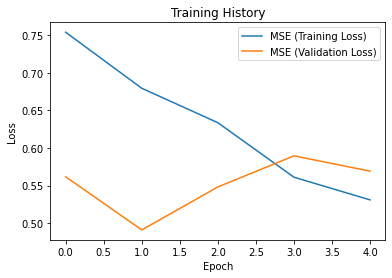

In [97]:
# Need to provide the trained model

save_model_dir = os.path.join(path, "saved_models/" + arguments.appliance_name + "_" + arguments.network_type + "_model.h5")
#save_path = os.path.join(path, "saved_models/" )
#os.mkdir(save_path)
inputoffset = 0.1
trainer = Trainer(arguments.appliance_name, arguments.batch_size, 500000, arguments.network_type,
                  arguments.training_directory, arguments.validation_directory,
                  save_model_dir,
                  epochs = arguments.epochs, offset=inputoffset, input_window_length = arguments.input_window_length,
                  validation_frequency = arguments.validation_frequency )
model = trainer.train_model()

# Test

In [98]:
#seq2point_test.py
import argparse
import os
import logging
import numpy as np 
import keras
import pandas as pd
import tensorflow as tf 
import time
#from model_structure import create_model, load_model
#from data_feeder import TestSlidingWindowGenerator
from data_feeder_offset import TestSlidingWindowGenerator

from appliance_data import appliance_data, mains_data
import matplotlib.pyplot as plt

class Tester():

    """ Used to test and evaluate a pre-trained seq2point model with or without pruning applied. 
    
    Parameters:
    __appliance (string): The target appliance.
    __algorithm (string): The (pruning) algorithm the model was trained with.
    __network_type (string): The architecture of the model.
    __crop (int): The maximum number of rows of data to evaluate the model with.
    __batch_size (int): The number of rows per testing batch.
    __window_size (int): The size of eaech sliding window
    __window_offset (int): The offset of the inferred value from the sliding window.
    __test_directory (string): The directory of the test file for the model.
    
    """

    def __init__(self, model, appliance, algorithm, crop, batch_size, network_type,
                 test_directory, saved_model_dir, log_file_dir, offset,
                 input_window_length):
        self.model = model
        self.__appliance = appliance
        self.__algorithm = algorithm
        self.__network_type = network_type

        self.__crop = crop
        self.__batch_size = batch_size
        self.__input_window_length = input_window_length
        self.__window_size = self.__input_window_length + 2
        self.__window_offset = int(offset * self.__window_size - 1)
        self.__number_of_windows = 100

        self.__test_directory = test_directory
        self.__saved_model_dir = saved_model_dir

        self.__log_file = log_file_dir
        logging.basicConfig(filename=self.__log_file,level=logging.INFO)

    def test_model(self):

        """ Tests a fully-trained model using a sliding window generator as an input. Measures inference time, gathers, and 
        plots evaluationg metrics. """

        test_input, test_target = self.load_dataset(self.__test_directory)
        #model = create_model(self._input_window_length)
        #model = load_model(model, self.__network_type, self.__algorithm, 
        #                   self.__appliance, self.__saved_model_dir)
        model = self.model
        test_generator = TestSlidingWindowGenerator(number_of_windows=self.__number_of_windows, inputs=test_input, targets=test_target, offset=self.__window_offset, windowlength = self.__input_window_length)

        # Calculate the optimum steps per epoch.
        steps_per_test_epoch = np.round(int(test_generator.total_size / self.__batch_size), decimals=0)

        # Test the model.
        start_time = time.time()
        testing_history = model.predict(x=test_generator.load_dataset(), steps=steps_per_test_epoch, verbose=2)

        end_time = time.time()
        test_time = end_time - start_time

        evaluation_metrics = model.evaluate(x=test_generator.load_dataset(), steps=steps_per_test_epoch)

        self.log_results(model, test_time, evaluation_metrics)
        self.plot_results(testing_history, test_input, test_target)


    def load_dataset(self, directory):
        """Loads the testing dataset from the location specified by file_name.

        Parameters:
        directory (string): The location at which the dataset is stored, concatenated with the file name.

        Returns:
        test_input (numpy.array): The first n (crop) features of the test dataset.
        test_target (numpy.array): The first n (crop) targets of the test dataset.

        """

        data_frame = pd.read_csv(directory, nrows=self.__crop, skiprows=0, header=0)
        test_input = np.round(np.array(data_frame.iloc[:, 0], float), 6)
        test_target = np.round(np.array(data_frame.iloc[self.__window_offset: -self.__window_offset, 1], float), 6)
        
        del data_frame
        return test_input, test_target

    def log_results(self, model, test_time, evaluation_metrics):

        """Logs the inference time, MAE and MSE of an evaluated model.

        Parameters:
        model (tf.keras.Model): The evaluated model.
        test_time (float): The time taken by the model to infer all required values.
        evaluation metrics (list): The MSE, MAE, and various compression ratios of the model.

        """

        inference_log = "Inference Time: " + str(test_time)
        logging.info(inference_log)

        metric_string = "MSE: ", str(evaluation_metrics[0]), " MAE: ", str(evaluation_metrics[3])
        logging.info(metric_string)

        self.count_pruned_weights(model)  

    def count_pruned_weights(self, model):

        """ Counts the total number of weights, pruned weights, and weights in convolutional 
        layers. Calculates the sparsity ratio of different layer types and logs these values.

        Parameters:
        model (tf.keras.Model): The evaluated model.

        """
        num_total_zeros = 0
        num_dense_zeros = 0
        num_dense_weights = 0
        num_conv_zeros = 0
        num_conv_weights = 0
        for layer in model.layers:
            if np.shape(layer.get_weights())[0] != 0:
                layer_weights = layer.get_weights()[0].flatten()

                if "conv" in layer.name:
                    num_conv_weights += np.size(layer_weights)
                    num_conv_zeros += np.count_nonzero(layer_weights==0)

                    num_total_zeros += np.size(layer_weights)
                else:
                    num_dense_weights += np.size(layer_weights)
                    num_dense_zeros += np.count_nonzero(layer_weights==0)

        conv_zeros_string = "CONV. ZEROS: " + str(num_conv_zeros)
        conv_weights_string = "CONV. WEIGHTS: " + str(num_conv_weights)
        conv_sparsity_ratio = "CONV. RATIO: " + str(num_conv_zeros / num_conv_weights)

        dense_weights_string = "DENSE WEIGHTS: " + str(num_dense_weights)
        dense_zeros_string = "DENSE ZEROS: " + str(num_dense_zeros)
        dense_sparsity_ratio = "DENSE RATIO: " + str(num_dense_zeros / num_dense_weights)

        total_zeros_string = "TOTAL ZEROS: " + str(num_total_zeros)
        total_weights_string = "TOTAL WEIGHTS: " + str(model.count_params())
        total_sparsity_ratio = "TOTAL RATIO: " + str(num_total_zeros / model.count_params())

        print("LOGGING PATH: ", self.__log_file)

        logging.info(conv_zeros_string)
        logging.info(conv_weights_string)
        logging.info(conv_sparsity_ratio)
        logging.info("")
        logging.info(dense_zeros_string)
        logging.info(dense_weights_string)
        logging.info(dense_sparsity_ratio)
        logging.info("")
        logging.info(total_zeros_string)
        logging.info(total_weights_string)
        logging.info(total_sparsity_ratio)

    def plot_results(self, testing_history, test_input, test_target):

        """ Generates and saves a plot of the testing history of the model against the (actual) 
        aggregate energy values and the true appliance values.

        Parameters:
        testing_history (numpy.ndarray): The series of values inferred by the model.
        test_input (numpy.ndarray): The aggregate energy data.
        test_target (numpy.ndarray): The true energy values of the appliance.

        """

        testing_history = ((testing_history * 50.75) + 4.22)
        test_target = ((test_target * 50.75) + 4.22)
        test_agg = (test_input.flatten() * mains_data["std"]) + mains_data["mean"]
        test_agg = test_agg[:testing_history.size]

        # Can't have negative energy readings - set any results below 0 to 0.
        test_target[test_target < 0] = 0
        testing_history[testing_history < 0] = 0
        test_input[test_input < 0] = 0

        # Plot testing outcomes against ground truth.
        plt.figure(1)
        print(self.__window_offset)
        print(test_agg.size)
        print(test_target.size)
        print(testing_history.size)
        plt.plot(test_agg[self.__window_offset: -self.__window_offset], label="Aggregate")
        plt.plot(test_target[:test_agg.size - (2 * self.__window_offset)], label="Ground Truth")
        plt.plot(testing_history[:test_agg.size - (2 * self.__window_offset)], label="Predicted")
        plt.title(self.__appliance + " " + self.__network_type + "(" + self.__algorithm + ")")
        plt.ylabel("Power Value (Watts)")
        plt.xlabel("Testing Window")
        plt.legend()
        x1 = 4500
        x2 = 6000
        plt.figure(2)
        plt.plot(test_agg[self.__window_offset + x1: x2], label="Aggregate")
        plt.plot(test_target[x1:x2], label="Ground Truth")
        plt.plot(testing_history[x1:x2], label="Predicted")
        x3 = 4900
        x4 = 5500
        plt.figure(3)
        plt.plot(test_agg[self.__window_offset + x3: x4], label="Aggregate")
        plt.plot(test_target[x3:x4], label="Ground Truth")
        plt.plot(testing_history[x3:x4], label="Predicted")

        #file_path = "./" + self.__appliance + "/saved_models/" + self.__appliance + "_" + self.__algorithm + "_" + self.__network_type + "_test_figure.png"
        #plt.savefig(fname=file_path)

        plt.show()

In [99]:
test_directory= "/content/drive/MyDrive/energy_disaggregation/seq2point-nilm/train_kitchenoutlet_stove/stove_test_.csv"

In [100]:
parser = argparse.ArgumentParser(description="Train a pruned neural network for energy disaggregation. ")
parser.add_argument("-f", "--fff", help="a dummy argument to fool ipython", default="1")
parser.add_argument("--appliance_name", type=remove_space, default="stove", help="The name of the appliance to perform disaggregation with. Default is kettle. Available are: kettle, fridge, dishwasher, microwave. ")
parser.add_argument("--batch_size", type=int, default="500", help="The batch size to use when training the network. Default is 1000. ")
parser.add_argument("--crop", type=int, default="10000", help="The number of rows of the dataset to take training data from. Default is 10000. ")
parser.add_argument("--algorithm", type=remove_space, default="seq2point", help="The pruning algorithm of the model to test. Default is none. ")
parser.add_argument("--network_type", type=remove_space, default="", help="The seq2point architecture to use. Only use if you do not want to use the standard architecture. Available are: default, dropout, reduced, and reduced_dropout. ")
parser.add_argument("--offset", type=float, default="0.1", help="Offset from window")
parser.add_argument("--input_window_length", type=int, default="199", help="Number of input data points to network. Default is 599. ")
parser.add_argument("--test_directory", type=str, default=test_directory, help="The dir for training data. ")

arguments = parser.parse_args()

In [101]:
# You need to provide the trained model
saved_model_dir = os.path.join(path, "saved_models/" + arguments.appliance_name + "_" + arguments.network_type + "_model.h5")

#"saved_models/" + arguments.appliance_name + "_" + arguments.algorithm + "_model.h5"

In [102]:
# The logs including results will be recorded to this log file
log_file_dir = os.path.join(path,"saved_models/" + arguments.appliance_name + "_" + arguments.algorithm + "_" + arguments.network_type + ".log")
#save_path = os.path.join(path, "saved_models/" )

In [103]:
df_test = pd.read_csv(test_directory)
len(df_test)

139083

In [104]:
tester = Tester(model, arguments.appliance_name, arguments.algorithm, 190000, 
                arguments.batch_size, arguments.network_type,
                arguments.test_directory, saved_model_dir, log_file_dir, arguments.offset,
                arguments.input_window_length)

278/278 - 1s
278/278 [==============================] - 1s 3ms/step - loss: 1.6644 - mse: 1.6644 - msle: 0.0221 - mae: 0.1060
LOGGING PATH:  /content/drive/MyDrive/energy_disaggregation/seq2point-nilm/saved_models/stove_seq2point_.log
19
27800
139045
27800


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


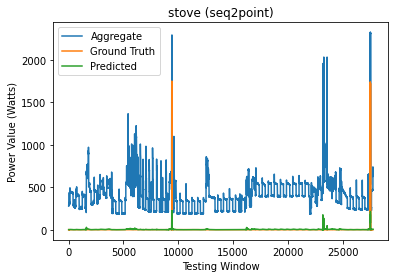

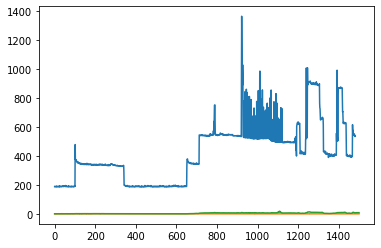

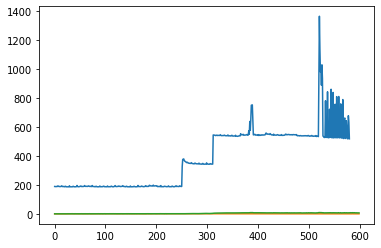

In [105]:
tester.test_model()
